In [1]:
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
device = 'cpu'
class StockPriceDataset(Dataset):
    def __init__(self,
                 data_path: str,
                 input_sequence: int,
                 output_sequence: int,
                 flag: str='train',
                 train_split: float = 0.7,
                 val_split: float = 0.1
                 ):
        """
        :param data_path: file path of the csv file
        :param input_sequence: window size for input
        :param output_sequence: horizon size for output
        :param flag: configure for data purpose like train or validation or test
        """
        self.input_sequence = input_sequence
        self.output_sequence = output_sequence
        df = pd.read_csv(data_path, index_col=0)
        df.reset_index(drop=True, inplace=True)
        self.n_features = df.shape[1]
        num_train = int(len(df)*train_split)
        num_valid = int(len(df)*val_split)
        if flag == 'val':
            df = df[num_valid:num_train+num_valid]
        elif flag == 'test':
            df = df[num_train+num_valid:]
        else:
            df = df[:num_train]
        self.scaler = StandardScaler()
        self.scaler.fit_transform(df[:num_train].values)
        self.data = torch.tensor(self.scaler.transform(df.values)).float()
    
    def __len__(self):
        return len(self.data) - self.input_sequence - self.output_sequence + 1
    
    def __getitem__(self, index):
        x_begin = index
        x_end = x_begin + self.input_sequence
        y_begin = x_end
        y_end = y_begin + self.output_sequence
        return self.data[x_begin: x_end], self.data[y_begin:y_end]



class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        self.sec_phase_lstm = nn.LSTMCell(input_size=self.N+1, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
        
        self.W_e2 = nn.Linear(2*self.M, self.T)
        self.U_e2 = nn.Linear(self.T, self.T, bias=False)
        self.v_e2 = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs, target_history):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M))
        x_tilde = torch.zeros((inputs.size(0), self.T, self.N))
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M))
        s_tm1 = torch.zeros((inputs.size(0), self.M))
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :]
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            x_tilde[:, t, :] = weighted_inputs
            encoded_inputs[:, t, :] = h_tm1
        
        #second phase attention
        h_tm2 = torch.zeros((inputs.size(0), self.M))
        s_tm2 = torch.zeros((inputs.size(0), self.M))
        z = torch.cat((x_tilde, target_history), dim=2)
        z_tilde = torch.zeros((inputs.size(0), self.T, self.N+1))
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat_2 = torch.cat((h_tm2, s_tm2), dim=1)
            
            #attention weights for each k in N (equation 8)
            x2 = self.W_e2(h_c_concat_2).unsqueeze(1).repeat(1, self.N+1, 1)
            y2 = self.U_e2(z.permute(0, 2, 1))
            z2 = torch.tanh(x2 + y2)
            e_k_t2 = torch.squeeze(self.v_e2(z2))
        
            #normalize attention weights (equation 9)
            alpha_k_t2 = F.softmax(e_k_t2, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs2 = alpha_k_t2 * z[:, t, :]
    
            #calculate next hidden states (equation 11)
            h_tm2, s_tm2 = self.sec_phase_lstm(weighted_inputs2, (h_tm2, s_tm2))
            z_tilde[:, t, :] = weighted_inputs2
            encoded_inputs[:, t, :] = h_tm2

        return encoded_inputs

class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, pred_len, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, pred_len)
        
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P))
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P))
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

class DSTP_RNN(nn.Module):
    def __init__(self, N, M, P, T, pred_len, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder)
        self.decoder = TemporalAttentionDecoder(M, P, T, pred_len, stateful_decoder)
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history, y_history), y_history)
        return out


hidden_size = 256
num_layers = 1
learning_rate = 0.001
epochs = 100
input_sequence = 48
output_sequence = 96
batch_size=128
train_dataset = StockPriceDataset('VN30_price.csv', input_sequence, output_sequence)
val_dataset = StockPriceDataset('VN30_price.csv', input_sequence, output_sequence, flag='val')
test_dataset = StockPriceDataset('VN30_price.csv', input_sequence, output_sequence, flag='test')
n_features = train_dataset.n_features


class Optim(object):

    def _makeOptimizer(self):
        if self.method == 'sgd':
            self.optimizer = optim.SGD(self.params, lr=self.lr)
        elif self.method == 'adagrad':
            self.optimizer = optim.Adagrad(self.params, lr=self.lr)
        elif self.method == 'adadelta':
            self.optimizer = optim.Adadelta(self.params, lr=self.lr)
        elif self.method == 'adam':
            self.optimizer = optim.Adam(self.params, lr=self.lr)
        else:
            raise RuntimeError("Invalid optim method: " + self.method)

    def __init__(self, params, method, lr, max_grad_norm, lr_decay=1, start_decay_at=None):
        self.params = list(params)  # careful: params may be a generator
        self.last_ppl = None
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.method = method
        self.lr_decay = lr_decay
        self.start_decay_at = start_decay_at
        self.start_decay = False

        self._makeOptimizer()

    def step(self):
        # Compute gradients norm.
        grad_norm = 0
        for param in self.params:
            grad_norm += math.pow(param.grad.data.norm(), 2)

        grad_norm = math.sqrt(grad_norm)
        if grad_norm > 0:
            shrinkage = self.max_grad_norm / grad_norm
        else:
            shrinkage = 1.

        for param in self.params:
            if shrinkage < 1:
                param.grad.data.mul_(shrinkage)

        self.optimizer.step()
        return grad_norm

    # decay learning rate if val perf does not improve or we hit the start_decay_at limit
    def updateLearningRate(self, ppl, epoch):
        if self.start_decay_at is not None and epoch >= self.start_decay_at:
            self.start_decay = True
        if self.last_ppl is not None and ppl > self.last_ppl:
            self.start_decay = True

        if self.start_decay:
            self.lr = self.lr * self.lr_decay
            print("Decaying learning rate to %g" % self.lr)
        #only decay for one epoch
        self.start_decay = False

        self.last_ppl = ppl

        self._makeOptimizer()
        
model = DSTP_RNN(n_features-1, hidden_size, hidden_size, input_sequence, output_sequence)
criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), learning_rate)
optimizer = Optim(model.parameters(), 'adam', learning_rate, 10)
model.train()
for epoch in range(epochs):
    test_loss = 0
    n_item = 0
    for i, (input, true_output) in enumerate(DataLoader(train_dataset, batch_size=batch_size)):
        model.zero_grad()
        x = input[:, :, :-1]
        y_history = input[:, :, -1:]
        output = model(x, y_history)
        # true_output = torch.squeeze(true_output[:, :, [0]], 1)
        true_output = true_output[:, :, -1]
        loss = criterion(output, true_output)
        test_loss += loss.item()
        n_item += 1
        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('epoch number {}, iter {}, LOSS {}'.format(epoch+1, i+1, test_loss/n_item) )
    if (epoch+1) % 10 == 0:
        print (f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')
        pred = []
        true = []
        for i, (input, true_output) in enumerate(DataLoader(val_dataset, batch_size=batch_size)):
            model.eval()
            model.zero_grad()
            x = input[:, :, :-1]
            y_history = input[:, :, -1:]
            output = model(x, y_history)
            # true_output = torch.squeeze(true_output, 1)
            pred_price = output.detach().numpy()
            # pred_price = output.squeeze().detach().numpy()
            true_price = true_output[:, :, -1].detach().numpy()
            pred.extend(pred_price)
            true.extend(true_price)
        print('Val RMSE')
        print(np.sqrt(np.mean((np.array(pred)-np.array(true))**2)))


epoch number 1, iter 8, LOSS 0.8744788859039545
epoch number 2, iter 8, LOSS 0.8535869410261512
epoch number 3, iter 8, LOSS 0.8333941334858537
epoch number 4, iter 8, LOSS 0.8195716817863286
epoch number 5, iter 8, LOSS 0.8154359511099756
epoch number 6, iter 8, LOSS 0.8121111975051463
epoch number 7, iter 8, LOSS 0.8092603939585388
epoch number 8, iter 8, LOSS 0.8065636521205306
epoch number 9, iter 8, LOSS 0.8030088576488197
epoch number 10, iter 8, LOSS 0.7950592436827719
Epoch [10], Loss: 1.7104
Val RMSE
0.858734
epoch number 11, iter 8, LOSS 0.7789109530858696
epoch number 12, iter 8, LOSS 0.7889185398817062
epoch number 13, iter 8, LOSS 0.7864144779741764
epoch number 14, iter 8, LOSS 0.7665106123313308
epoch number 15, iter 8, LOSS 0.7336041983217001
epoch number 16, iter 8, LOSS 0.7168299173936248
epoch number 17, iter 8, LOSS 0.6687734364531934
epoch number 18, iter 8, LOSS 0.6495567327365279
epoch number 19, iter 8, LOSS 0.5924485381692648
epoch number 20, iter 8, LOSS 0.542

Result ================================
RMSE
0.7310600740940699


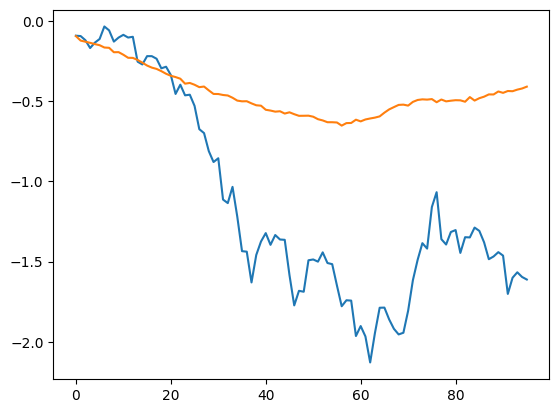

In [12]:
print("Result ================================")
pred = []
true = []
for i, (input, true_output) in enumerate(DataLoader(test_dataset, batch_size=300)):
    model.eval()
    model.zero_grad()
    x = input[:, :, :-1]
    y_history = input[:, :, -1:]
    output = model(x, y_history)
    # true_output = torch.squeeze(true_output, 1)
    pred_price = output.detach().tolist()
    pred.extend(pred_price)
    # pred_price = output.squeeze().detach().numpy()
    true_price = true_output[:, :, -1].detach().tolist()
    true.extend(true_price)

# print(pred_price)
# print(true_price)
import matplotlib.pyplot as plt
plt.plot(np.array(true)[-1, :])
plt.plot(np.array(pred)[-1, :])
print('RMSE')
print(np.sqrt(np.mean((np.array(pred_price)-np.array(true_price))**2)))
    
# %%


In [7]:
np.array(true).shape

(157, 96)